In [43]:
import os
import torch

!pip install torch-geometric

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
from torch_geometric.nn.models import InnerProductDecoder
from torch.nn import init, Dropout
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import random_split

from tqdm import trange

Set various arguments for use throughout the Colab



In [20]:
import torch.optim as optim

def build_optimizer(args, params):
    '''
    Optimizer construction from Colab 4 from the Fall 2024 offering of CS224W
    '''
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(
    {'batch_size': 128,'epochs': 2000,
          'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-4, 'lr': 0.003,
          'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')}
    )

Import data: you must download the `Compiled_data.dat` file from the [Github repo](https://github.com/jshin029-github/GraphFold3D) in order for you to run this Colab!

In [41]:
with open('Compiled_data.dat','rb') as f:
    all_data = torch.load(f)

# Move data to GPU if available
all_data = [data.to(args.device) for data in all_data]

<ipython-input-41-be66ccf980de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data = torch.load(f)


Define the GNN Modules


In [47]:
class HeteroGNNContainer(torch.nn.Module):
    '''
    Code template taken from the pytorch-geometric tutorial
    https://pytorch-geometric.readthedocs.io/en/2.5.1/notes/heterogeneous.html
    '''
    def __init__(self, hidden_channels, out_channels,
                 num_node_features, num_layers, convConstructor,
                 device, normalize=False, dropout=0,
                 pos_edges = ('nuc','FR3D','nuc'),
                 neg_edges = ('nuc','neg_FR3D','nuc')):
        super().__init__()

        # Construct the relevant GraphConv stack
        self.convs = convConstructor(hidden_channels, num_layers, dropout, normalize)

        # Initialize the linear layers
        self.enc_lin = Linear(num_node_features,hidden_channels,bias=True)
        self.mp_lin = Linear(hidden_channels, out_channels,bias=True)

        init.xavier_uniform_(self.enc_lin.weight)
        init.xavier_uniform_(self.mp_lin.weight)

        # Initialize the inner product decoder
        self.dec = InnerProductDecoder()

        # Define the positive and negative edges used for training
        #   default is (nuc,FR3D,nuc) and (nuc,neg_FR3D,nuc), respectively
        self.pos_edges = pos_edges
        self.neg_edges = neg_edges

        # Store the device info
        self.device = device

        # Initialize dropout layer
        self.drop_layer = Dropout(p=dropout)

    def forward(self, x_dict, edge_index_dict):
        '''
        Defines the forward pass operation. Takes the x_dict and edge_index_dict
        from a HeteroData object and performs Message passing
        '''

        # Project the node features to a hidden_channels-dim vector
        x = self.enc_lin(x_dict['nuc'])

        # Apply layers of message passing with activation and dropout
        for conv in self.convs:
            x = x.tanh()
            x = conv({'nuc':x}, edge_index_dict)['nuc']
            x = self.mp_lin(x)
            x = self.drop_layer(x)

        return x

    def pred_pos_scores(self,x,edge_index_dict):
        '''
        Use the decoder to predict positive edge scores
        '''
        return self.dec(x,edge_index_dict[self.pos_edges],sigmoid=False)

    def pred_neg_scores(self,x,edge_index_dict):
        '''
        Use the decoder to predict negative edge scores
        '''
        return self.dec(x,edge_index_dict[self.neg_edges],sigmoid=False)

    def calculateBCELoss(self,pos_scores,neg_scores):
        '''
        cross entropy loss for positive and negative edge predictions
        '''

        # Make vector of labels for the positive and negative edges
        labels = torch.cat([
            torch.ones(len(pos_scores),device=self.device),
            torch.zeros(len(neg_scores),device=self.device)
            ])

        # Combine positive and negative edge scores
        predictions = torch.cat([pos_scores,neg_scores])

        # Compute and return the binary cross entropy loss
        return binary_cross_entropy_with_logits(predictions,labels,reduction='sum')

In [6]:
def GATConvConstructor(hidden_channels, num_layers, dropout=0, normalize=False):
    convs = torch.nn.ModuleList()
    for _ in range(num_layers):
        conv = HeteroConv({
            ('nuc', 'mxfold', 'nuc'): GATConv((-1, -1), hidden_channels, dropout=dropout, add_self_loops=False),
            ('nuc', 'connected', 'nuc'): GATConv((-1, -1), hidden_channels, dropout=dropout, add_self_loops=False),
        }, aggr='mean')
        convs.append(conv)

    return convs

def SAGEConvConstructor(hidden_channels, num_layers, dropout=0, normalize=False):
    convs = torch.nn.ModuleList()
    for _ in range(num_layers):
        conv = HeteroConv({
            ('nuc', 'mxfold', 'nuc'): SAGEConv((-1, -1), hidden_channels,normalize=normalize),
            ('nuc', 'connected', 'nuc'): SAGEConv((-1, -1), hidden_channels,normalize=normalize),
        }, aggr='mean')
        convs.append(conv)

    return convs

def GCNConvConstructor(hidden_channels, num_layers, dropout=0, normalize=False):
    convs = torch.nn.ModuleList()
    for _ in range(num_layers):
        conv = HeteroConv({
            ('nuc', 'mxfold', 'nuc'): GCNConv(-1,  hidden_channels,normalize=normalize, add_self_loops=False),
            ('nuc', 'connected', 'nuc'): GCNConv(-1, hidden_channels,normalize=normalize, add_self_loops=False),
        }, aggr='mean')
        convs.append(conv)

    return convs

Define the training loop and helper functions

In [8]:
def calculateConfusion(pos_scores,neg_scores,cutoff=0.5):
    '''
    Calculate the confusion matrix for edge predictions
    '''

    # Classify positive labels
    pos_labels = pos_scores.detach().sigmoid().cpu() > cutoff

    # Classify negative labels
    neg_labels = neg_scores.detach().sigmoid().cpu() > cutoff

    # Generate true labels
    labels = torch.cat([torch.ones(len(pos_scores)),
                    torch.zeros(len(neg_scores))])

    # Calculate and return confusion
    return confusion_matrix(
        labels,torch.cat([pos_labels,neg_labels])
    )


In [55]:
def test(test_loader, test_model):
    '''
    Define the test helper function to test the model
    '''
    # Set the model for testing mode
    test_model.eval()

    # Initialize loss and confusion matrices
    total_loss = 0
    total_confusion = np.zeros((2,2))

    # Loop through data batches
    for batch in test_loader:
        # Predict edges without training the model
        with torch.no_grad():
            # Encode node features
            x = test_model(batch.x_dict,batch.edge_index_dict)

            # Decode edge predictions using nodes
            pos_scores = test_model.pred_pos_scores(x,batch.edge_index_dict)
            neg_scores = test_model.pred_neg_scores(x,batch.edge_index_dict)

            # Calculate the loss and confusion matrix parameters
            loss = test_model.calculateBCELoss(pos_scores, neg_scores)
            confusion = calculateConfusion(pos_scores.cpu(),neg_scores.cpu())

        # Add to running total
        total_confusion += confusion
        total_loss += loss.item()

    # Normalize the loss by the number of graphs in the dataset
    total_loss /= len(test_loader.dataset)

    return total_loss, total_confusion

def train(train_loader, test_loader, model,scheduler, opt, verbose=True):
    '''
    Define the training loop for the model
    '''

    # Initialize data structures to keep track of training and testing performance
    losses = []
    confusions = []
    test_losses = []
    test_confusions = []

    # Loop over epochs
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
      # Initialize loss and confusion matrices
        total_loss = 0
        total_confusion = np.zeros((2,2))

        # Reset the model for training mode
        model.train()

        # Loop over batches
        for batch in train_loader:

            # Clear gradient, encode node features, predict edges, calculate
            #   loss, backprop, update running totals
            opt.zero_grad()
            x = model(batch.x_dict,batch.edge_index_dict)
            pos_scores = model.pred_pos_scores(x,batch.edge_index_dict)
            neg_scores = model.pred_neg_scores(x,batch.edge_index_dict)
            loss = model.calculateBCELoss(pos_scores, neg_scores)
            loss.backward()
            opt.step()
            total_loss += loss.item()
            total_confusion += calculateConfusion(pos_scores.cpu(),neg_scores.cpu())

        # Normalize the loss per graph
        total_loss /= len(train_loader.dataset)

        # Test and store model performance every 20 epochs
        if epoch % 20 == 0:
            test_loss, test_confusion = test(test_loader,model)

            losses.append(total_loss)
            confusions.append(calculateConfusion(pos_scores,neg_scores))
            test_losses.append(test_loss)
            test_confusions.append(test_confusion)

            # Print the results every 100 epochs to make sure training is happening
            if verbose & (epoch % 100 == 0):
                print((
                f"\nTrain Loss {total_loss:.1f}, Train Pos Acc % "
                f"{total_confusion[1,1]/total_confusion[1,:].sum()*100:.0f}, "
                f"Neg Acc % {total_confusion[0,0]/total_confusion[0,:].sum()*100:.0f}"
                f"\nTest Loss {test_loss:.1f}, Test Pos Acc % "
                f"{test_confusion[1,1]/test_confusion[1,:].sum()*100:.0f}, "
                f"Neg Acc % {test_confusion[0,0]/test_confusion[0,:].sum()*100:.0f}"
                ))

    return model, losses, confusions, test_losses, test_confusions

Perform Data split and set up DataLoaders

In [22]:
train_set, test_set = random_split(all_data,[0.8,0.2])
test_loader = DataLoader(test_set,batch_size=args.batch_size)
train_loader = DataLoader(train_set,batch_size=args.batch_size)

In [56]:

model = HeteroGNNContainer(
    hidden_channels=64, out_channels=64, dropout=0.1,
    num_node_features = 6, num_layers = 2, normalize=False,
    convConstructor = GCNConvConstructor,
    device = args.device).to(args.device)

scheduler, opt = build_optimizer(args, model.parameters())

model, losses, confusions, test_losses, test_confusions = train(
    train_loader,test_loader,model,scheduler, opt)

GCN_results_dropout = {
    'model':model,
    'losses':losses,
    'confusions':confusions,
    'test_losses':test_losses,
    'test_confusions':test_confusions,
}

Training:   0%|          | 1/2000 [00:00<16:23,  2.03Epochs/s]


Train Loss 100.2, Train Pos Acc % 88, Neg Acc % 24
Test Loss 88.8, Test Pos Acc % 78, Neg Acc % 45


Training:   5%|▌         | 101/2000 [00:43<15:55,  1.99Epochs/s]


Train Loss 91.9, Train Pos Acc % 75, Neg Acc % 54
Test Loss 84.3, Test Pos Acc % 76, Neg Acc % 53


Training:  10%|█         | 201/2000 [01:28<13:05,  2.29Epochs/s]


Train Loss 91.7, Train Pos Acc % 75, Neg Acc % 54
Test Loss 84.3, Test Pos Acc % 74, Neg Acc % 55


Training:  15%|█▌        | 301/2000 [02:12<13:41,  2.07Epochs/s]


Train Loss 91.7, Train Pos Acc % 76, Neg Acc % 53
Test Loss 84.2, Test Pos Acc % 75, Neg Acc % 54


Training:  20%|██        | 401/2000 [02:56<11:35,  2.30Epochs/s]


Train Loss 91.5, Train Pos Acc % 76, Neg Acc % 53
Test Loss 84.6, Test Pos Acc % 74, Neg Acc % 53


Training:  25%|██▌       | 501/2000 [03:40<10:47,  2.31Epochs/s]


Train Loss 91.3, Train Pos Acc % 76, Neg Acc % 54
Test Loss 84.6, Test Pos Acc % 74, Neg Acc % 54


Training:  30%|███       | 601/2000 [04:24<10:10,  2.29Epochs/s]


Train Loss 91.1, Train Pos Acc % 76, Neg Acc % 54
Test Loss 84.6, Test Pos Acc % 75, Neg Acc % 53


Training:  35%|███▌      | 701/2000 [05:07<09:17,  2.33Epochs/s]


Train Loss 91.0, Train Pos Acc % 77, Neg Acc % 53
Test Loss 84.9, Test Pos Acc % 75, Neg Acc % 53


Training:  40%|████      | 801/2000 [05:51<09:11,  2.18Epochs/s]


Train Loss 90.8, Train Pos Acc % 77, Neg Acc % 53
Test Loss 84.9, Test Pos Acc % 75, Neg Acc % 53


Training:  45%|████▌     | 901/2000 [06:38<09:58,  1.84Epochs/s]


Train Loss 90.6, Train Pos Acc % 77, Neg Acc % 54
Test Loss 85.0, Test Pos Acc % 75, Neg Acc % 53


Training:  50%|█████     | 1001/2000 [07:30<07:00,  2.38Epochs/s]


Train Loss 90.5, Train Pos Acc % 78, Neg Acc % 53
Test Loss 85.2, Test Pos Acc % 75, Neg Acc % 53


Training:  55%|█████▌    | 1101/2000 [08:13<07:29,  2.00Epochs/s]


Train Loss 90.3, Train Pos Acc % 77, Neg Acc % 54
Test Loss 85.3, Test Pos Acc % 75, Neg Acc % 53


Training:  60%|██████    | 1201/2000 [08:56<05:38,  2.36Epochs/s]


Train Loss 90.2, Train Pos Acc % 77, Neg Acc % 54
Test Loss 85.5, Test Pos Acc % 75, Neg Acc % 53


Training:  65%|██████▌   | 1301/2000 [09:40<06:17,  1.85Epochs/s]


Train Loss 90.1, Train Pos Acc % 78, Neg Acc % 54
Test Loss 85.5, Test Pos Acc % 76, Neg Acc % 52


Training:  70%|███████   | 1401/2000 [10:24<04:13,  2.36Epochs/s]


Train Loss 90.0, Train Pos Acc % 78, Neg Acc % 54
Test Loss 85.8, Test Pos Acc % 75, Neg Acc % 52


Training:  75%|███████▌  | 1501/2000 [11:06<03:29,  2.39Epochs/s]


Train Loss 89.9, Train Pos Acc % 78, Neg Acc % 54
Test Loss 85.9, Test Pos Acc % 75, Neg Acc % 52


Training:  80%|████████  | 1601/2000 [11:50<03:02,  2.19Epochs/s]


Train Loss 89.7, Train Pos Acc % 78, Neg Acc % 54
Test Loss 86.2, Test Pos Acc % 75, Neg Acc % 52


Training:  85%|████████▌ | 1701/2000 [12:32<02:04,  2.39Epochs/s]


Train Loss 89.6, Train Pos Acc % 78, Neg Acc % 54
Test Loss 86.2, Test Pos Acc % 75, Neg Acc % 52


Training:  90%|█████████ | 1801/2000 [13:14<01:22,  2.41Epochs/s]


Train Loss 89.5, Train Pos Acc % 78, Neg Acc % 54
Test Loss 86.5, Test Pos Acc % 75, Neg Acc % 52


Training:  95%|█████████▌| 1901/2000 [13:57<00:43,  2.28Epochs/s]


Train Loss 89.3, Train Pos Acc % 78, Neg Acc % 54
Test Loss 86.4, Test Pos Acc % 75, Neg Acc % 52


Training: 100%|██████████| 2000/2000 [14:40<00:00,  2.27Epochs/s]


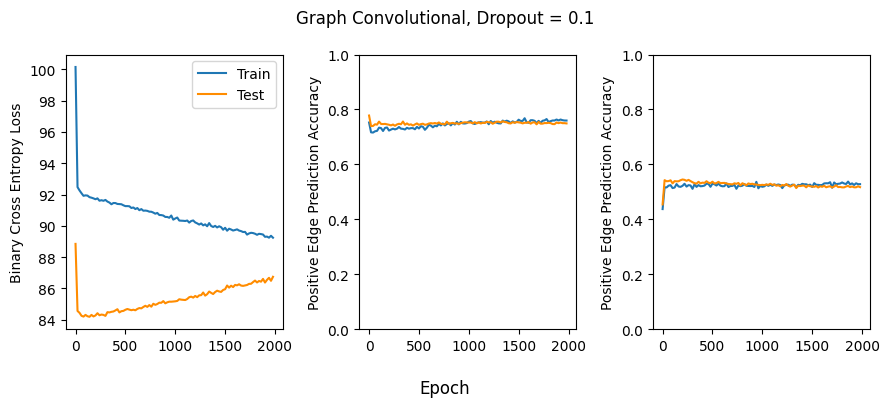

In [58]:
fig,axs = plt.subplots(ncols=3,figsize=(9,4),sharex=True)

epoch_range = np.arange(len(GCN_results_dropout['losses'])) * 20

axs[0].plot(epoch_range, GCN_results_dropout['losses'],color='tab:blue',label='Train')
axs[0].plot(epoch_range, GCN_results_dropout['test_losses'],color='darkorange',label='Test')

axs[0].set_ylabel('Binary Cross Entropy Loss')


axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in GCN_results_dropout['confusions']],color='tab:blue',label='Train')
axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in GCN_results_dropout['test_confusions']],color='darkorange',label='Test')

axs[1].set_ylabel('Positive Edge Prediction Accuracy')

axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in GCN_results_dropout['confusions']],color='tab:blue',label='Train')
axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in GCN_results_dropout['test_confusions']],color='darkorange',label='Test')

axs[2].set_ylabel('Positive Edge Prediction Accuracy')

axs[0].legend()

for ax in axs[1:]:
    ax.set_ylim((0,1))

fig.suptitle('Graph Convolutional, Dropout = 0.1')
fig.supxlabel('Epoch')
plt.tight_layout()

plt.show()

In [59]:

model = HeteroGNNContainer(
    hidden_channels=32, out_channels=64,dropout=0.1,
    num_node_features = 6, num_layers = 2 ,normalize=False,
    convConstructor = SAGEConvConstructor,
    device = args.device, pos_edges = ('nuc','FR3D','nuc')
                  ).to(args.device)

scheduler, opt = build_optimizer(args, model.parameters())

model, losses, confusions, test_losses, test_confusions = train(
    train_loader,test_loader,model,scheduler, opt)

SAGE_results = {
    'model':model,
    'losses':losses,
    'confusions':confusions,
    'test_losses':test_losses,
    'test_confusions':test_confusions,
}

Training:   0%|          | 1/2000 [00:00<31:19,  1.06Epochs/s]


Train Loss 103.9, Train Pos Acc % 98, Neg Acc % 4
Test Loss 90.1, Test Pos Acc % 91, Neg Acc % 21


Training:   5%|▌         | 101/2000 [00:45<13:57,  2.27Epochs/s]


Train Loss 86.0, Train Pos Acc % 82, Neg Acc % 49
Test Loss 79.8, Test Pos Acc % 82, Neg Acc % 50


Training:  10%|█         | 201/2000 [01:28<13:00,  2.30Epochs/s]


Train Loss 84.2, Train Pos Acc % 84, Neg Acc % 50
Test Loss 78.8, Test Pos Acc % 83, Neg Acc % 50


Training:  15%|█▌        | 301/2000 [02:12<12:54,  2.19Epochs/s]


Train Loss 83.4, Train Pos Acc % 84, Neg Acc % 50
Test Loss 78.4, Test Pos Acc % 83, Neg Acc % 50


Training:  20%|██        | 401/2000 [02:55<11:21,  2.35Epochs/s]


Train Loss 82.6, Train Pos Acc % 85, Neg Acc % 51
Test Loss 78.5, Test Pos Acc % 83, Neg Acc % 50


Training:  25%|██▌       | 501/2000 [03:40<11:20,  2.20Epochs/s]


Train Loss 82.0, Train Pos Acc % 85, Neg Acc % 52
Test Loss 78.4, Test Pos Acc % 83, Neg Acc % 49


Training:  30%|███       | 601/2000 [04:24<10:01,  2.32Epochs/s]


Train Loss 81.7, Train Pos Acc % 85, Neg Acc % 52
Test Loss 78.7, Test Pos Acc % 83, Neg Acc % 50


Training:  35%|███▌      | 701/2000 [05:08<11:02,  1.96Epochs/s]


Train Loss 81.2, Train Pos Acc % 85, Neg Acc % 53
Test Loss 78.9, Test Pos Acc % 83, Neg Acc % 49


Training:  40%|████      | 801/2000 [05:52<08:31,  2.34Epochs/s]


Train Loss 80.9, Train Pos Acc % 85, Neg Acc % 53
Test Loss 78.8, Test Pos Acc % 83, Neg Acc % 50


Training:  45%|████▌     | 901/2000 [06:36<11:27,  1.60Epochs/s]


Train Loss 80.6, Train Pos Acc % 86, Neg Acc % 53
Test Loss 79.0, Test Pos Acc % 83, Neg Acc % 49


Training:  50%|█████     | 1001/2000 [07:20<07:19,  2.27Epochs/s]


Train Loss 80.3, Train Pos Acc % 85, Neg Acc % 53
Test Loss 79.3, Test Pos Acc % 83, Neg Acc % 49


Training:  55%|█████▌    | 1101/2000 [08:06<08:33,  1.75Epochs/s]


Train Loss 80.0, Train Pos Acc % 86, Neg Acc % 54
Test Loss 79.5, Test Pos Acc % 82, Neg Acc % 49


Training:  60%|██████    | 1201/2000 [08:50<05:47,  2.30Epochs/s]


Train Loss 79.9, Train Pos Acc % 86, Neg Acc % 54
Test Loss 79.6, Test Pos Acc % 83, Neg Acc % 49


Training:  65%|██████▌   | 1301/2000 [09:34<06:17,  1.85Epochs/s]


Train Loss 79.6, Train Pos Acc % 86, Neg Acc % 54
Test Loss 80.2, Test Pos Acc % 82, Neg Acc % 49


Training:  70%|███████   | 1401/2000 [10:18<04:24,  2.26Epochs/s]


Train Loss 79.4, Train Pos Acc % 86, Neg Acc % 54
Test Loss 80.1, Test Pos Acc % 82, Neg Acc % 49


Training:  75%|███████▌  | 1501/2000 [11:02<05:01,  1.65Epochs/s]


Train Loss 79.1, Train Pos Acc % 86, Neg Acc % 55
Test Loss 80.1, Test Pos Acc % 83, Neg Acc % 49


Training:  80%|████████  | 1601/2000 [11:47<03:59,  1.66Epochs/s]


Train Loss 79.2, Train Pos Acc % 86, Neg Acc % 55
Test Loss 80.4, Test Pos Acc % 82, Neg Acc % 49


Training:  85%|████████▌ | 1701/2000 [12:42<02:54,  1.71Epochs/s]


Train Loss 78.9, Train Pos Acc % 86, Neg Acc % 55
Test Loss 80.7, Test Pos Acc % 82, Neg Acc % 49


Training:  90%|█████████ | 1801/2000 [13:39<02:03,  1.61Epochs/s]


Train Loss 78.9, Train Pos Acc % 86, Neg Acc % 55
Test Loss 80.7, Test Pos Acc % 82, Neg Acc % 49


Training:  95%|█████████▌| 1901/2000 [14:38<00:42,  2.31Epochs/s]


Train Loss 78.5, Train Pos Acc % 86, Neg Acc % 55
Test Loss 80.9, Test Pos Acc % 82, Neg Acc % 48


Training: 100%|██████████| 2000/2000 [15:35<00:00,  2.14Epochs/s]


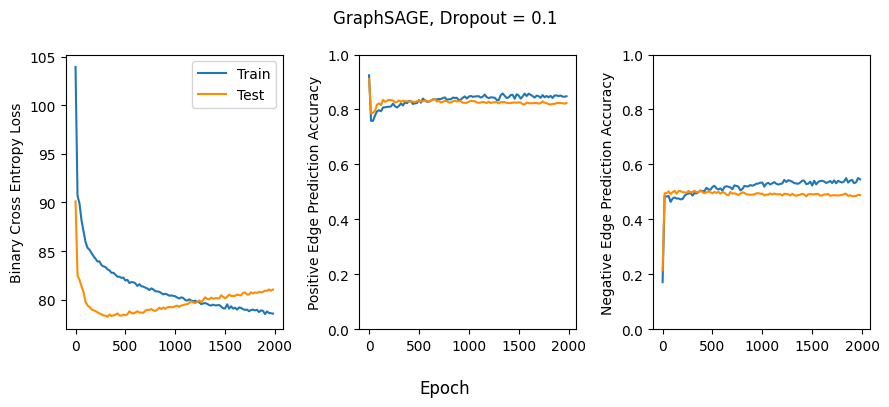

In [61]:
fig,axs = plt.subplots(ncols=3,figsize=(9,4),sharex=True)

epoch_range = np.arange(len(SAGE_results['losses'])) * 20

axs[0].plot(epoch_range, SAGE_results['losses'],color='tab:blue',label='Train')
axs[0].plot(epoch_range, SAGE_results['test_losses'],color='darkorange',label='Test')

axs[0].set_ylabel('Binary Cross Entropy Loss')


axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in SAGE_results['confusions']],color='tab:blue',label='Train')
axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in SAGE_results['test_confusions']],color='darkorange',label='Test')

axs[1].set_ylabel('Positive Edge Prediction Accuracy')

axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in SAGE_results['confusions']],color='tab:blue',label='Train')
axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in SAGE_results['test_confusions']],color='darkorange',label='Test')

axs[2].set_ylabel('Negative Edge Prediction Accuracy')

axs[0].legend()

for ax in axs[1:]:
    ax.set_ylim((0,1))

fig.suptitle('GraphSAGE, Dropout = 0.1')
fig.supxlabel('Epoch')
plt.tight_layout()

plt.show()

In [ ]:

model = HeteroGNNContainer(
    hidden_channels=64, out_channels=64,dropout=0.1,
    num_node_features = 6, num_layers = 2 ,normalize=False,
    convConstructor = GATConvConstructor,
    device = args.device, pos_edges = ('nuc','FR3D','nuc')
                  ).to(args.device)

scheduler, opt = build_optimizer(args, model.parameters())

model, losses, confusions, test_losses, test_confusions = train(
    train_loader,test_loader,model,scheduler, opt)

GAT_results = {
    'model':model,
    'losses':losses,
    'confusions':confusions,
    'test_losses':test_losses,
    'test_confusions':test_confusions,
}

Training:   0%|          | 1/2000 [00:00<30:21,  1.10Epochs/s]


Train Loss 103.7, Train Pos Acc % 91, Neg Acc % 14
Test Loss 90.5, Test Pos Acc % 87, Neg Acc % 29


Training:   5%|▌         | 101/2000 [00:48<20:18,  1.56Epochs/s]


Train Loss 94.8, Train Pos Acc % 72, Neg Acc % 52
Test Loss 85.0, Test Pos Acc % 74, Neg Acc % 54


Training:  10%|█         | 201/2000 [01:35<13:51,  2.16Epochs/s]


Train Loss 94.6, Train Pos Acc % 72, Neg Acc % 52
Test Loss 84.9, Test Pos Acc % 74, Neg Acc % 54


Training:  15%|█▌        | 301/2000 [02:22<12:53,  2.20Epochs/s]


Train Loss 94.6, Train Pos Acc % 72, Neg Acc % 52
Test Loss 85.0, Test Pos Acc % 75, Neg Acc % 53


Training:  20%|██        | 401/2000 [03:09<14:27,  1.84Epochs/s]


Train Loss 94.5, Train Pos Acc % 72, Neg Acc % 52
Test Loss 84.9, Test Pos Acc % 74, Neg Acc % 54


Training:  24%|██▍       | 479/2000 [03:45<14:09,  1.79Epochs/s]

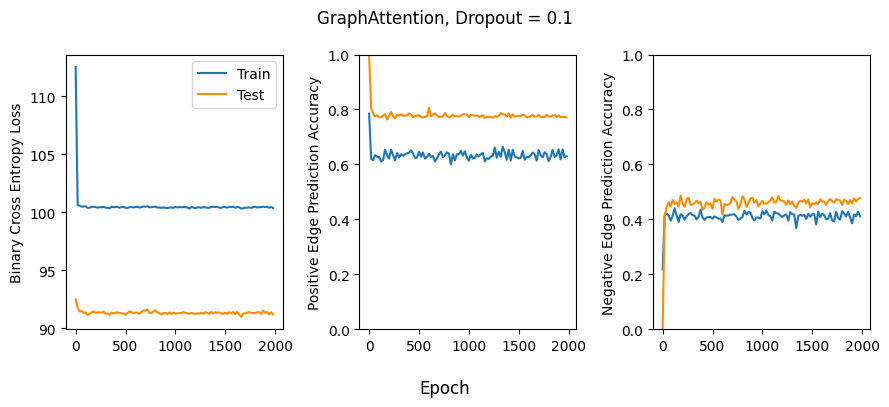

In [63]:
fig,axs = plt.subplots(ncols=3,figsize=(9,4),sharex=True)

epoch_range = np.arange(len(GAT_results['losses'])) * 20

axs[0].plot(epoch_range, GAT_results['losses'],color='tab:blue',label='Train')
axs[0].plot(epoch_range, GAT_results['test_losses'],color='darkorange',label='Test')

axs[0].set_ylabel('Binary Cross Entropy Loss')


axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in GAT_results['confusions']],color='tab:blue',label='Train')
axs[1].plot(epoch_range, [M[1,1] / M[1,:].sum() for M in GAT_results['test_confusions']],color='darkorange',label='Test')

axs[1].set_ylabel('Positive Edge Prediction Accuracy')

axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in GAT_results['confusions']],color='tab:blue',label='Train')
axs[2].plot(epoch_range, [M[0,0] / M[0,:].sum() for M in GAT_results['test_confusions']],color='darkorange',label='Test')

axs[2].set_ylabel('Negative Edge Prediction Accuracy')

axs[0].legend()

for ax in axs[1:]:
    ax.set_ylim((0,1))

fig.suptitle('GraphAttention, Dropout = 0.1')
fig.supxlabel('Epoch')
plt.tight_layout()

plt.show()